# Métricas do reprocessamento

Código feito por Igor Laltuf, ago/23

---

## Objetivo

Analisar o impacto do reprocessamento das viagens da linha 010 entre 01/06/2022 até 31/05/2023

## Etapas
Comparar valores pré e pós reprocessamento segundo as seguintes variáveis:
- A quantidade de viagens completas
- Quilometragem total de viagens completas
- Quilometragem total de viagens válidas (POD >= 80%)
- Valor do subsídio a ser pago
- Explicações pontuais sobre os resultados encontrados

## Conclusão

Sobre o período entre 01/06/2022 e 31/05/2023:

1) A linha 010 não teve viagens planejadas no mês de junho de 2022.

2) A quilometragem total das viagens completas aumentou de 66.790,1 km para 81.485,2 km, um aumento de 22% após o reprocessamento.

3) A quantidade de viagens identificadas aumentou de 6.414 para 15.670 viagens.

4) O valor do subsídio antes do reprocessamento era de R$ 100.756,68 e após o reprocessamento foi de R$ 136.049,75.

5) A mudança do shape acarretou na redução da quilometragem planejada para o dia, principalmente aos finais de semana, o que aumentou o valor do POD entre agosto de 2022 e janeiro de 2023.  

6) O valor do subsídio a ser pago em abril e maio de 2023 foi menor após o reprocessamento, pois aumentou a quantidade de dias em que o POD < 80%.


### Carregar bibliotecas

In [3]:
#!pip install matplotlib
import basedosdados as bd
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import folium
from datetime import timedelta, datetime
from shapely import wkt

# Paths
import os
import sys
from pathlib import Path 

current_path = Path().resolve()

paths = dict()
paths["raw"] = current_path / 'data' / 'raw'
paths["treated"] = current_path / 'data' / 'treated'

for path in paths.values():
    if not os.path.exists(path):
        os.makedirs(path)

# Seta o projeto a ser cobrado
bd.config.billing_project_id = "rj-smtr-dev"

# Seta as configurações a serem usadas
bd.config.project_config_path = "C:/Users/igorl/.basedosdados/"
# bd.config.project_config_path = "D:\\basedosdados\\dev"

### 1. Comparar a variação na km após o reprocessamento

In [4]:
q = f"""
SELECT
  FORMAT_DATETIME('%Y-%m', DATA) AS mes_ano,
  SUM(ROUND(distancia_planejada,2)) AS distancia_total
FROM
  `rj-smtr.projeto_subsidio_sppo.viagem_completa`
WHERE
  DATA BETWEEN "2022-06-01"
  AND "2023-05-31"
  AND servico_informado = "010"
GROUP BY
  mes_ano
"""

viagens_realizadas_010 = bd.read_sql(q, from_file=True)

viagens_realizadas_010.to_csv('data/treated/viagens_realizadas_010_jun_22-maio_23.csv', index=False)

Downloading: 100%|██████████| 11/11 [00:00<00:00, 32.26rows/s]


In [6]:
q = f"""
SELECT
  FORMAT_DATETIME('%Y-%m', DATA) AS mes_ano,
  SUM(ROUND(distancia_planejada,2)) AS distancia_total
FROM
  `rj-smtr-dev.SMTR202212006611_reprocessamento.viagem_completa`
WHERE
  DATA BETWEEN "2022-06-01"
  AND "2023-05-31"
GROUP BY
  mes_ano
"""
viagens_reprocessadas_010 = bd.read_sql(q, from_file=True)

viagens_reprocessadas_010.to_csv('data/treated/viagens_reprocessadas_010_jun_22-maio_23.csv', index=False)

Downloading: 100%|██████████| 11/11 [00:00<00:00, 34.70rows/s]


Não existem viagens planejadas para a linha 010 no mês de junho de 2022.

In [8]:
q = f"""
SELECT
  COUNT(*) AS total_linhas
FROM
  `rj-smtr.projeto_subsidio_sppo.viagem_planejada`
WHERE
  DATA BETWEEN "2022-06-01"
  AND "2022-06-30"
  AND servico = '010'
"""
viagens_planejadas_jun_2022_010 = bd.read_sql(q, from_file=True)

viagens_planejadas_jun_2022_010

Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.02rows/s]


,total_linhas
0,0


In [26]:
viagens_reprocessadas_010 = pd.read_csv('data/treated/viagens_reprocessadas_010_jun_22-maio_23.csv')
viagens_realizadas_010 = pd.read_csv('data/treated/viagens_realizadas_010_jun_22-maio_23.csv')

km_mes_ano = pd.merge(viagens_realizadas_010, viagens_reprocessadas_010, how = 'left', on='mes_ano', suffixes=['','_reprocessada'])
km_mes_ano = km_mes_ano.sort_values('mes_ano')
km_mes_ano

,mes_ano,distancia_total,distancia_total_reprocessada
9,2022-07,4235.04,4965.7
6,2022-08,6825.10,8751.9
8,2022-09,6408.30,7929.1
5,2022-10,7356.52,8211.1
3,2022-11,6658.38,7626.3
10,2022-12,6793.84,7546.7
1,2023-01,5933.70,7790.8
4,2023-02,3747.60,4716.6
0,2023-03,6412.56,8070.4
2,2023-04,5860.83,7484.4


In [40]:
distancia_total_pre_reprocessamento = km_mes_ano['distancia_total'].sum()
distancia_total_pos_reprocessamento = km_mes_ano['distancia_total_reprocessada'].sum()
print("Comparação da quilometragem das viagens completas")
print("Valor total da km pré-reprocessamento:", distancia_total_pre_reprocessamento)
print("Valor total da km pós-reprocessamento:", distancia_total_pos_reprocessamento)
print("Aumento de ",round((distancia_total_pos_reprocessamento / distancia_total_pre_reprocessamento - 1) * 100, 2),"%")

Comparação da quilometragem das viagens completas
Valor total da km pré-reprocessamento: 66790.16999999998
Valor total da km pós-reprocessamento: 81485.2
Aumento de  22.0 %


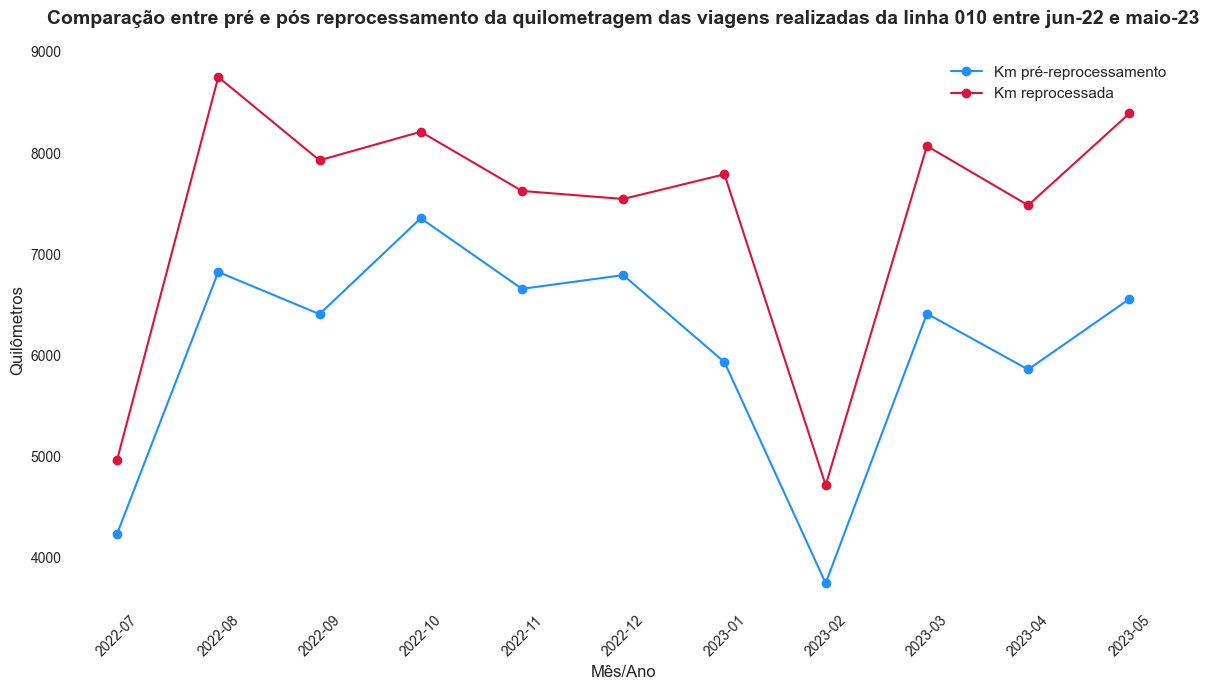

In [69]:
# Definindo o tamanho da figura
plt.figure(figsize=(12, 7))

# Plotando as duas séries de dados
plt.plot(km_mes_ano['mes_ano'], km_mes_ano['distancia_total'], 
         color='dodgerblue', marker='o', label='Km pré-reprocessamento')
plt.plot(km_mes_ano['mes_ano'], km_mes_ano['distancia_total_reprocessada'], 
         color='crimson', marker='o', label='Km reprocessada')

# Título, legendas e rótulos
plt.title('Comparação entre pré e pós reprocessamento da quilometragem das viagens realizadas da linha 010 entre jun-22 e maio-23', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Quilômetros', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=False, fontsize=11)  # frameon=False remove a caixa em torno da legenda

# Remover o fundo e as bordas
ax = plt.gca()
ax.set_facecolor('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)  # Remove a grade

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 2. Comparar a variação no valor do subsídio após o reprocessamento

2.1 Valor recebido pelos consórcios antes do reprocessamento

In [62]:
q = f"""
SELECT
  CONCAT(CAST(EXTRACT(YEAR FROM DATA) AS STRING), '-', LPAD(CAST(EXTRACT(MONTH FROM DATA) AS STRING), 2, '0')) AS mes_ano,
  SUM(viagens) as viagens,
  
  SUM(valor_subsidio_pago) AS valor_subsidio
FROM
  `rj-smtr.dashboard_subsidio_sppo.sumario_servico_dia_historico`
WHERE
  servico = '010'
  AND DATA BETWEEN '2022-06-01' AND '2023-05-31'
GROUP BY
  mes_ano
"""
subsidio_pago_mes = bd.read_sql(q, from_file=True)

subsidio_pago_mes = subsidio_pago_mes.sort_values('mes_ano')
subsidio_pago_mes

Downloading: 100%|██████████| 11/11 [00:00<00:00, 29.18rows/s]


,mes_ano,viagens,valor_subsidio
6,2022-07,408,4433.15
1,2022-08,655,9864.75
3,2022-09,615,9426.57
0,2022-10,706,11781.44
10,2022-11,639,9692.20
9,2022-12,652,11609.69
7,2023-01,570,8479.80
5,2023-02,360,5175.60
2,2023-03,616,9824.87
4,2023-04,563,10526.68


In [63]:
subsidio_pago_mes = subsidio_pago_mes[['mes_ano', 'viagens', 'valor_subsidio']]
subsidio_pago_mes

,mes_ano,viagens,valor_subsidio
6,2022-07,408,4433.15
1,2022-08,655,9864.75
3,2022-09,615,9426.57
0,2022-10,706,11781.44
10,2022-11,639,9692.20
9,2022-12,652,11609.69
7,2023-01,570,8479.80
5,2023-02,360,5175.60
2,2023-03,616,9824.87
4,2023-04,563,10526.68


2.2 Valor que deve ser pago após o reprocessamento

Com base nas viagens identificadas na tabela de viagem completa que foi reprocessada, foram verificados aqueles dias em que POD >= 80%, para então calcular o valor do subsídio de acordo com os valores por km da tabela `subsidio_data_versao_efetiva` que também está no dataset `rj-smtr-dev.SMTR202212006611_reprocessamento`.

Vale destacar que esta tabela exclui as glosas de 2023 do valor do subsídio por km (ex: considera 2.81 por km após 16 de janeiro de 2023). 

Também não inclui o valor das penalidades.

In [53]:
q = f"""
WITH
  viagem_dia AS (
  SELECT
    DATA,
    COUNT(*) AS viagens,
    SUM(distancia_planejada) AS km_apurada
  FROM
    `rj-smtr-dev.SMTR202212006611_reprocessamento.viagem_completa`
  WHERE
    DATA BETWEEN "2022-06-01"
    AND "2023-05-31"
  GROUP BY
    consorcio,
    DATA,
    tipo_dia,
    id_empresa,
    servico_informado ),
  viagem_planejada AS (
  SELECT
    DISTINCT DATA,
    distancia_total_planejada,
  FROM
    `rj-smtr-dev.SMTR202212006611_reprocessamento.viagem_planejada`
  WHERE
    servico = '010'
    AND sentido = "V"
    AND DATA BETWEEN "2022-06-01"
    AND "2023-05-31"),
  tabela_pod AS (
  SELECT
    *,
    ROUND((km_apurada / distancia_total_planejada),2) AS perc_km_planejada
  FROM
    viagem_dia vd
  RIGHT JOIN
    viagem_planejada vp
  USING
    (DATA) ),
  tabela_subsidio_km AS (
  SELECT
    DATA,
    valor_subsidio_por_km
  FROM
    `rj-smtr-dev.SMTR202212006611_reprocessamento.subsidio_data_versao_efetiva` )
SELECT
  DATA,
  COALESCE(viagens, 0) as viagens,
  COALESCE(km_apurada,0) as km_apurada,
  COALESCE(distancia_total_planejada,0) as distancia_total_planejada,
  COALESCE(perc_km_planejada,0) as perc_km_planejada,
  COALESCE(valor_subsidio_por_km,0) as valor_subsidio_por_km,
   CASE 
   WHEN perc_km_planejada >= 0.8 THEN valor_subsidio_por_km * km_apurada
   ELSE 0
   END as valor_subsidio
FROM
  tabela_pod
LEFT JOIN
  tabela_subsidio_km
USING
  (DATA)
"""

subsidio_a_pagar_dia = bd.read_sql(q, from_file=True)
subsidio_a_pagar_dia = subsidio_a_pagar_dia.sort_values('DATA')
subsidio_a_pagar_dia

Downloading: 100%|██████████| 408/408 [00:00<00:00, 1130.19rows/s]


,DATA,viagens,km_apurada,distancia_total_planejada,perc_km_planejada,valor_subsidio_por_km,valor_subsidio
89,2022-06-01,0,0.000,312.21,0.00,2.13,0.0
236,2022-06-02,0,0.000,312.21,0.00,2.13,0.0
178,2022-06-03,0,0.000,312.21,0.00,2.13,0.0
342,2022-06-04,0,0.000,88.08,0.00,2.13,0.0
241,2022-06-05,0,0.000,77.07,0.00,2.13,0.0
...,...,...,...,...,...,...,...
255,2023-05-29,28,145.698,312.21,0.47,2.81,0.0
258,2023-05-30,32,166.512,312.21,0.53,2.81,0.0
257,2023-05-30,32,166.512,312.21,0.53,2.81,0.0
136,2023-05-31,32,166.512,312.21,0.53,2.81,0.0


In [111]:
# Garanta que a coluna DATA é um tipo de data
subsidio_a_pagar_dia['DATA'] = pd.to_datetime(subsidio_a_pagar_dia['DATA'])

# Crie uma nova coluna mes_ano
subsidio_a_pagar_dia['mes_ano'] = subsidio_a_pagar_dia['DATA'].dt.strftime('%Y-%m')

# Agrupar pelo mes_ano e realizar alguma operação, como somar:
subsidio_a_pagar_mes = subsidio_a_pagar_dia[['mes_ano', 'viagens', 'valor_subsidio']]

subsidio_a_pagar_mes = subsidio_a_pagar_mes.groupby('mes_ano').sum().reset_index()  

subsidio_a_pagar_mes

,mes_ano,viagens,valor_subsidio
0,2022-06,0,0.00000
1,2022-07,955,5993.59944
2,2022-08,1683,14349.17160
3,2022-09,1525,12774.31050
4,2022-10,1579,13310.93736
5,2022-11,1467,11676.07872
6,2022-12,1451,12886.44528
7,2023-01,1498,21890.46987
8,2023-02,906,9999.42153
9,2023-03,1552,18131.07540


In [65]:
# juntar as duas tabelas
tabela_subsidio_mes = pd.merge(subsidio_pago_mes, subsidio_a_pagar_mes, how='left', on='mes_ano', suffixes=['_pre','_pos'])
tabela_subsidio_mes

# o valor não foi tão maior, porque o POD diário permaneceu baixo.

,mes_ano,viagens_pre,valor_subsidio_pre,viagens_pos,valor_subsidio_pos
0,2022-07,408,4433.15,955,5993.59944
1,2022-08,655,9864.75,1683,14349.17160
2,2022-09,615,9426.57,1525,12774.31050
3,2022-10,706,11781.44,1579,13310.93736
4,2022-11,639,9692.20,1467,11676.07872
5,2022-12,652,11609.69,1451,12886.44528
6,2023-01,570,8479.80,1498,21890.46987
7,2023-02,360,5175.60,906,9999.42153
8,2023-03,616,9824.87,1552,18131.07540
9,2023-04,563,10526.68,1440,9206.67276


In [145]:
tabela_subsidio_mes
total_subsidio_comparacao = tabela_subsidio_mes[['viagens_pre', 'viagens_pos','valor_subsidio_pre','valor_subsidio_pos']].sum(axis=0)
total_subsidio_comparacao

viagens_pre             6414.00000
viagens_pos            15670.00000
valor_subsidio_pre    100756.68000
valor_subsidio_pos    136049.75298
dtype: float64

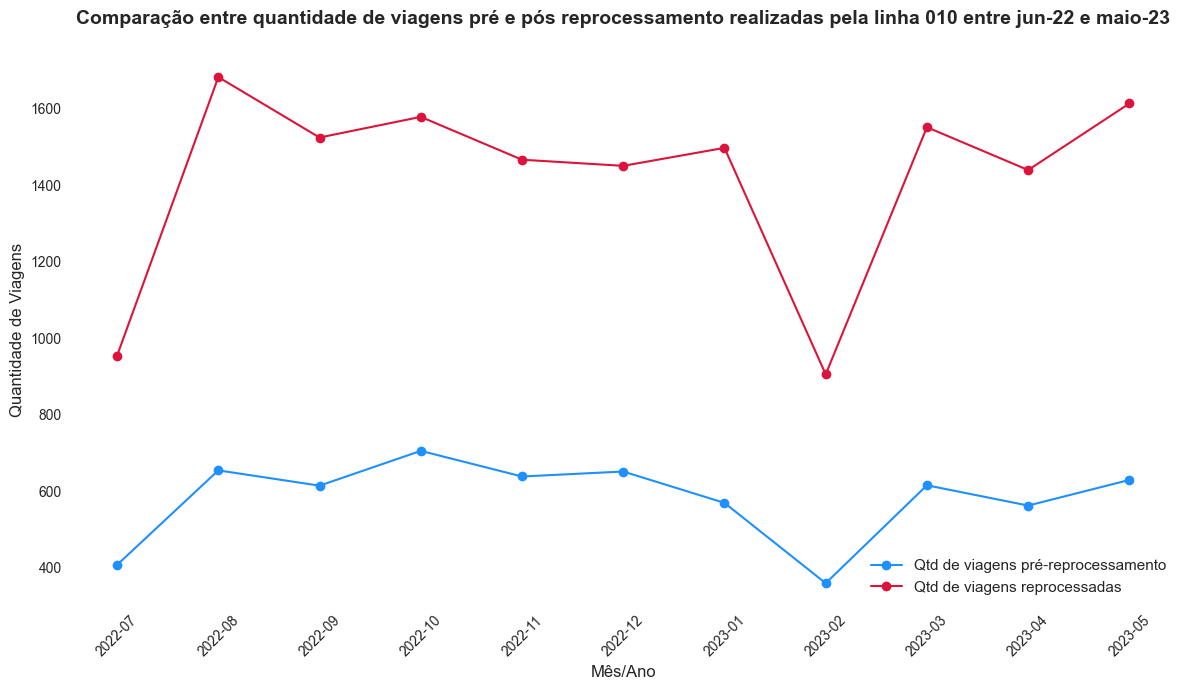

In [72]:
# Definindo o tamanho da figura
plt.figure(figsize=(12, 7))

# Plotando as duas séries de dados
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['viagens_pre'], 
         color='dodgerblue', marker='o', label='Qtd de viagens pré-reprocessamento')
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['viagens_pos'], 
         color='crimson', marker='o', label='Qtd de viagens reprocessadas')

# Título, legendas e rótulos
plt.title('Comparação entre quantidade de viagens pré e pós reprocessamento realizadas pela linha 010 entre jun-22 e maio-23', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Quantidade de Viagens', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=False, fontsize=11) 

# Remover o fundo e as bordas
ax = plt.gca()
ax.set_facecolor('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)  

# Exibir o gráfico
plt.tight_layout()
plt.show()

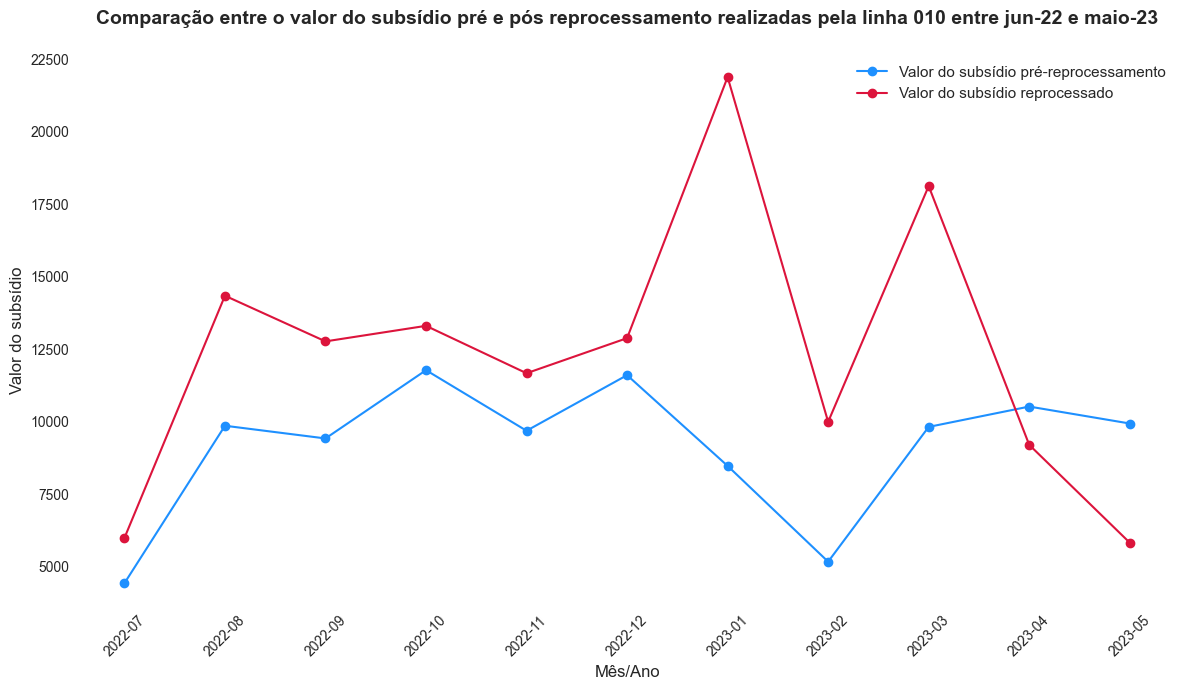

In [73]:
# Definindo o tamanho da figura
plt.figure(figsize=(12, 7))

# Plotando as duas séries de dados
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['valor_subsidio_pre'], 
         color='dodgerblue', marker='o', label='Valor do subsídio pré-reprocessamento')
plt.plot(tabela_subsidio_mes['mes_ano'], tabela_subsidio_mes['valor_subsidio_pos'], 
         color='crimson', marker='o', label='Valor do subsídio reprocessado')

# Título, legendas e rótulos
plt.title('Comparação entre o valor do subsídio pré e pós reprocessamento realizadas pela linha 010 entre jun-22 e maio-23', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês/Ano', fontsize=12)
plt.ylabel('Valor do subsídio', fontsize=12)
plt.xticks(rotation=45)
plt.legend(frameon=False, fontsize=11) 

# Remover o fundo e as bordas
ax = plt.gca()
ax.set_facecolor('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)  

# Exibir o gráfico
plt.tight_layout()
plt.show()

### 3. Análise do POD


3.1 POD pré-reprocessamento

In [102]:
# POD pré-reprocessamento
q = f"""
SELECT
  data, viagens, perc_km_planejada
FROM
  `rj-smtr.dashboard_subsidio_sppo.sumario_servico_dia_historico`
WHERE
  servico = '010'
  AND DATA BETWEEN '2022-06-01' AND '2023-05-31'
"""
pod_pre_reprocessamento = bd.read_sql(q, from_file=True)

pod_pre_reprocessamento = pod_pre_reprocessamento.sort_values('data')
pod_pre_reprocessamento

Downloading: 100%|██████████| 335/335 [00:00<00:00, 861.16rows/s]


,data,viagens,perc_km_planejada
229,2022-07-01,0,0.00
325,2022-07-02,0,0.00
255,2022-07-03,0,0.00
199,2022-07-04,0,0.00
261,2022-07-05,0,0.00
...,...,...,...
334,2023-05-27,13,81.25
51,2023-05-28,15,107.15
108,2023-05-29,22,73.33
54,2023-05-30,28,93.33


In [113]:
# Assegurando que a coluna 'data' seja do tipo datetime
pod_pre_reprocessamento['data'] = pd.to_datetime(pod_pre_reprocessamento['data'])
# Criando a nova coluna 'mes_ano'
pod_pre_reprocessamento['mes_ano'] = pod_pre_reprocessamento['data'].dt.to_period('M')
pod_pre_reprocessamento['mes_ano'] = pod_pre_reprocessamento['mes_ano'].astype(str)
pod_pre_reprocessamento

,data,viagens,perc_km_planejada,mes_ano
229,2022-07-01,0,0.00,2022-07
325,2022-07-02,0,0.00,2022-07
255,2022-07-03,0,0.00,2022-07
199,2022-07-04,0,0.00,2022-07
261,2022-07-05,0,0.00,2022-07
...,...,...,...,...
334,2023-05-27,13,81.25,2023-05
51,2023-05-28,15,107.15,2023-05
108,2023-05-29,22,73.33,2023-05
54,2023-05-30,28,93.33,2023-05


In [136]:

y = "perc_km_planejada"
title = f"Distribuição do percentual de operação diária (POD) por mês - Serviço: 010"

fig = px.box(
    pod_pre_reprocessamento, 
    x="mes_ano", 
    y=y, 
    title=title,
    template="plotly_white",
    labels={
        "mes_ano": "",
        y: ""
    },
    points="all"
)

fig.update_layout(
    yaxis_range=[-10, 200],  
    yaxis_ticksuffix="%",
    width=800,
    height=600,
    showlegend=False,
)

fig.add_hline(y=80, annotation_text="min = 80%")  # Linha horizontal para indicar o mínimo de 80%

fig.show()


3.2 POD pós-reprocessamento

In [116]:
pod_pos_reprocessamento = subsidio_a_pagar_dia[["mes_ano","viagens","perc_km_planejada"]]
pod_pos_reprocessamento['perc_km_planejada'] = pod_pos_reprocessamento['perc_km_planejada'] * 100
pod_pos_reprocessamento

,mes_ano,viagens,perc_km_planejada
89,2022-06,0,0.0
236,2022-06,0,0.0
178,2022-06,0,0.0
342,2022-06,0,0.0
241,2022-06,0,0.0
...,...,...,...
255,2023-05,28,47.0
258,2023-05,32,53.0
257,2023-05,32,53.0
136,2023-05,32,53.0


In [134]:

y = "perc_km_planejada"
title = "Distribuição do percentual de operação diária (POD) por mês - Serviço: 010 <br>Versão reprocessada"

fig = px.box(
    pod_pos_reprocessamento, 
    x="mes_ano", 
    y=y, 
    title=title,
    template="plotly_white",
    labels={
        "mes_ano": "",
        y: ""
    },
    points="all"
)

fig.update_layout(
    yaxis_range=[-50, 400],  
    yaxis_ticksuffix="%",
    width=800,
    height=600,
    showlegend=False,
)

fig.add_hline(y=80, annotation_text="min = 80%")  # Linha horizontal para indicar o mínimo de 80%

fig.show()


Nota-se que apesar do aumento geral do valor a ser pago após o reprocessamento, em abril e maio de 2023 o valor foi menor, já que o POD da maior parte dos dias ficou abaixo de 80%.

No novo shape o valor da distância planejada para os sábados e domingos é fixo em 88.08 km e 77.07 km, respectivamente. 

No shape original, estes valores eram maiores. O resultado é um aumento generalizado do POD, chegando a 360% em alguns casos.

In [137]:
maiores_perc_pos = subsidio_a_pagar_dia.sort_values(by='perc_km_planejada', ascending=False)
maiores_perc_pos

,DATA,viagens,km_apurada,distancia_total_planejada,perc_km_planejada,valor_subsidio_por_km,valor_subsidio,mes_ano
398,2022-10-29,61,317.112,88.08,3.60,1.62,513.72144,2022-10
53,2022-10-22,60,312.210,88.08,3.54,1.62,505.78020,2022-10
250,2022-11-05,60,312.210,88.08,3.54,1.53,477.68130,2022-11
40,2022-11-19,60,312.210,88.08,3.54,1.53,477.68130,2022-11
233,2022-09-02,60,312.210,88.08,3.54,1.75,546.36750,2022-09
...,...,...,...,...,...,...,...,...
319,2022-06-23,0,0.000,312.21,0.00,2.13,0.00000,2022-06
302,2022-06-22,0,0.000,312.21,0.00,2.13,0.00000,2022-06
177,2022-06-21,0,0.000,312.21,0.00,2.13,0.00000,2022-06
361,2022-06-20,0,0.000,312.21,0.00,2.13,0.00000,2022-06


In [139]:
q = f"""
SELECT
  *
FROM
  `rj-smtr.dashboard_subsidio_sppo.sumario_servico_dia_historico`
WHERE
  servico = '010'
  AND DATA = '2022-10-29'
"""

perc_pre_29_10_2022 = bd.read_sql(q, from_file=True)
perc_pre_29_10_2022

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.99rows/s]


,data,tipo_dia,consorcio,servico,vista,viagens,km_apurada,km_planejada,perc_km_planejada,valor_subsidio_pago,valor_penalidade
0,2022-10-29,Sabado,Intersul,010,Bairro de Fátima ↔ Central,27,281.313,156.292,179.99,455.73,NaN


#### Comparação entre a km planejada dos shapes:

In [140]:
q = f"""
    SELECT
      DISTINCT tipo_dia,
      distancia_total_planejada,
    FROM
      `rj-smtr-dev.SMTR202212006611_reprocessamento.viagem_planejada`
    WHERE
      servico = '010'
      AND tipo_dia IN ("Domingo", "Sabado")
      AND DATA BETWEEN "2022-06-01"
      AND "2023-05-31"
"""

fds_planejado_reprocessamento = bd.read_sql(q, from_file=True)
fds_planejado_reprocessamento

Downloading: 100%|██████████| 2/2 [00:00<00:00,  5.92rows/s]


,tipo_dia,distancia_total_planejada
0,Domingo,77.07
1,Sabado,88.08


In [142]:
q = f"""
    SELECT
    DISTINCT tipo_dia, perc_km_planejada
    FROM
    `rj-smtr.dashboard_subsidio_sppo.sumario_servico_dia_historico`
    WHERE
    tipo_dia IN ("Domingo", "Sabado")
    AND DATA BETWEEN '2022-06-01' 
    AND '2023-05-31'
"""

fds_planejado_original = bd.read_sql(q, from_file=True)
fds_planejado_original

Downloading: 100%|██████████| 12756/12756 [00:00<00:00, 23066.93rows/s]


,tipo_dia,perc_km_planejada
0,Sabado,97.86
1,Sabado,101.97
2,Sabado,116.47
3,Sabado,90.22
4,Sabado,300.00
...,...,...
12751,Sabado,120.38
12752,Domingo,208.52
12753,Domingo,64.61
12754,Sabado,72.25


### 4. Exportar planilha com dados

Exportar planilha resumo com valores a pagar antes e depois, assim como a km identificada na planilha de viagens completas.

In [159]:
km_mes_ano_soma = km_mes_ano[['distancia_total', 'distancia_total_reprocessada']].sum()
km_mes_ano_soma = km_mes_ano_soma.to_frame().T

km_mes_ano_soma = km_mes_ano_soma.rename(columns={
    'distancia_total': 'distancia_total_pre',
    'distancia_total_reprocessada': 'distancia_total_pos'
})
km_mes_ano_soma


tabela_subsidio_mes_soma = tabela_subsidio_mes[['viagens_pre', 'viagens_pos','valor_subsidio_pre', 'valor_subsidio_pos']].sum()
tabela_subsidio_mes_soma = tabela_subsidio_mes_soma.to_frame().T
tabela_subsidio_mes_soma

km_mes_ano_soma['key'] = 1
tabela_subsidio_mes_soma['key'] = 1

tabela_comparacao_exportar = km_mes_ano_soma.merge(tabela_subsidio_mes_soma, on='key', how='left').drop('key', axis=1)

tabela_comparacao_exportar
tabela_comparacao_exportar.to_excel("data/output/comparacao_pre_pos_reprocessamento_010.xlsx", index=False, engine='openpyxl')